The usual imports

In [1]:
import tables_io
import numpy as np
import matplotlib.pyplot as plt
import qp
from rail.core.data import DATA_STORE
from rail.utils.catalog_utils import RomanRubinCatalogConfig
DS = DATA_STORE()

In [2]:
from rail.raruma import utility_functions as raruma_util
from rail.raruma import plotting_functions as raruma_plot

Change this to be the root of the current PZ working area

In [3]:
pz_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1'

In [4]:
algo = 'knn'
d = tables_io.read(f"{pz_dir}/data/test/dp1_matched_test.hdf5")
pz = qp.read(f"{pz_dir}/projects/dp1/data/gold_dp1_optimize/output_estimate_{algo}.hdf5")
redshifts = d['redshift']

In [5]:
def calc_frac_dels(qp_dstn, truth):
    delta = np.squeeze(qp_dstn.ancil['zmode']) - truth
    return delta / (1 + truth)

In [6]:
def calc_std(qp_dstn, grid):
    pdfs = qp_dstn.pdf(grid)
    norms = pdfs.sum(axis=1)
    means = np.sum(pdfs * grid, axis=1) / norms
    diffs = (np.expand_dims(grid, -1) - means).T
    wt_diffs = diffs * diffs * pdfs
    stds = np.sqrt((wt_diffs).sum(axis=1)/norms)
    return np.expand_dims(stds, -1)

In [7]:
def effic_and_purirty_curves(std, frac_dels, cuts, purity_cut=0.05):
    effic_list = []
    purity_list = []    
    for cut_ in cuts:
        mask = np.abs(np.squeeze(std)) < cut_
        effic = mask.sum() / mask.size
        good_mask = np.abs(np.squeeze(frac_dels[mask])) < purity_cut
        purtiy = good_mask.sum() / good_mask.size        
        effic_list.append(effic)
        purity_list.append(purtiy)        
    return np.array(effic_list), np.array(purity_list)

In [8]:
grid = np.linspace(0., 4., 401)

In [9]:
std = calc_std(pz, grid)
frac_dels = calc_frac_dels(pz, redshifts)
cuts = np.linspace(0.01, 1.00, 100)

In [10]:
effic, purity = effic_and_purirty_curves(std, frac_dels, cuts, 0.20)

/tmp/ipykernel_100314/2211462524.py:8: RuntimeWarning: invalid value encountered in scalar divide
  purtiy = good_mask.sum() / good_mask.size


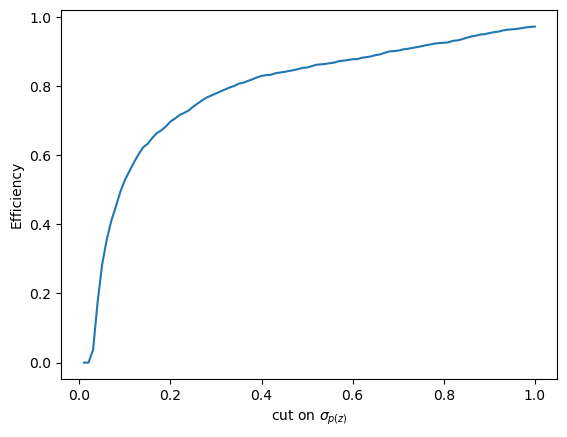

In [11]:
fig = plt.figure()
_ = plt.plot(cuts, effic)
_ = plt.xlabel(r'cut on $\sigma_{p(z)}$')
_ = plt.ylabel('Efficiency')
fig.savefig('efficiency.pdf')

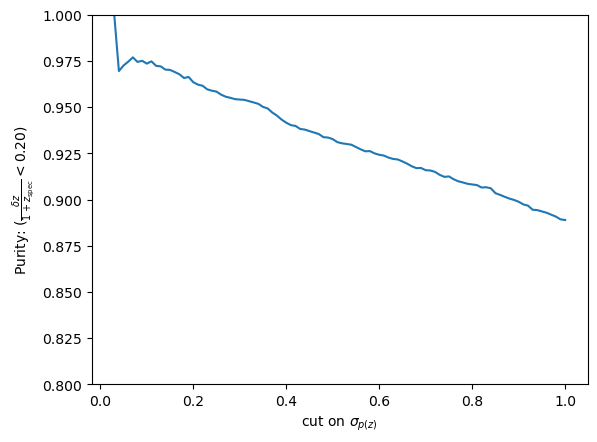

In [14]:
fig = plt.figure()
_ = plt.plot(cuts, purity)
_ = plt.xlabel(r'cut on $\sigma_{p(z)}$')
_ = plt.ylabel(r'Purity: ($\frac{\delta z}{1 + z_{\rm spec}} < 0.20)$')
_ = plt.ylim(0.8, 1.)
fig.savefig('purity.pdf')

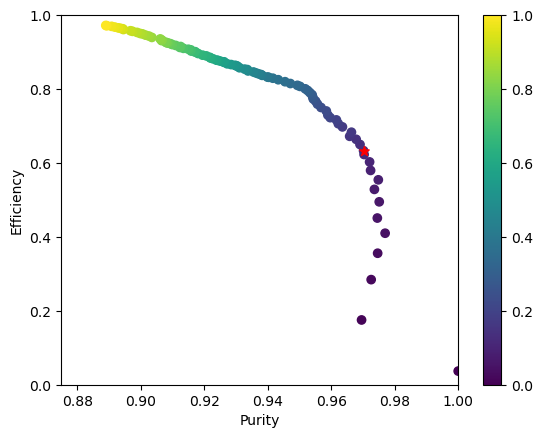

In [13]:
fig = plt.figure()
_ = plt.scatter(purity, effic, c=cuts)
mask = np.abs(cuts-0.15) < 0.0001
_ = plt.scatter(purity[mask], effic[mask], marker="*", s=50, color="red")

_ = plt.xlabel('Purity')
_ = plt.ylabel('Efficiency')
_ = plt.ylim(0, 1.)
_ = plt.xlim(0.875, 1.)
_ = plt.colorbar()
fig.savefig('purity_v_effic.pdf')